# Abstract

I am interested in Transposon sequencing analyses and I stumbled upon a paper <cite data-cite="6932338/9J4IFRXF"></cite> that performed a TraDis analysis of the *Escherishia coli* K12 genome. TraDis methods, for Transposon Directed Insertion Sequencing, uses specific PCR amplification of regions flanking transposons that have been inserted in the genome. This paper compare TraDis results to single genes deletion libraries to identify essential genes. It also discuss the importance of correction for gene and genome length, as well as the manual curration of any TraDis results. 

In this notebook, I replicate their analysis, then compare it with the results of software for TraDis Data. 

# Table of contents

<div id="toc"></div>

# Introduction

This notebook contain a comparison of methods to analyse TraDis data to predict essential genes in *Escherichia Coli* K12. 
The first step is to understand the biology of the technic to assess any systematic biases that we would need to account for. This will impact the pre-processing of the data, from the raw reads to the count of insertion at each insertion site. 

I first tried to replicate the exact analysis presented in the paper <cite data-cite="6932338/9J4IFRXF">.The paper present a simple method of ploting the genes saturations, and identifying the distributions corresponding to essential and essential genes. The genes are then classified in one distribution or the other, and we discuss the impact of the choices of thresholds and parameters.
    
The next step is to compare these results to the ones provided by a stand alone software, TRANSIT, that provides a classification based on the Gumbel distribution.

And finally we compare the two techniques single gene deletion mutants libraries, and manually inspect the genes that are classifies differently in each case.

*Disclaimer* : It is important to note that due to the random nature of TraDis techniques, a gene that seems incorrectly classified in regard of its biological function does not mean the method is failing. Always verify if the results are in accordance with the data before the biological meaning is analysed.


## TraDis techniques

The different TraDis techniques share a common principle : The genomes of a bacterial population are statistically  saturated with transposon insertions. It means that statistically, every possible insertion site for the transposon is impacted at least one time in the bacterial population. The transposon insertion is disruptive for the gene, which means that if the gene impacted is essential, then this insertion will kill the bacteria and disappear from the population. 

<img src="../Images/design_tnseq_a.png" alt="Design of Tnseq experiments-a" style="width: 900px;"/>


An initial population of genomes is mutated so that the genome of the bacteria is saturated with transposon insertions. A library is called saturated if in the genomes across the whole population of bacteria, each potential insertion site has at least one insertion. The population is then divided into several media containing different growth conditions, to identify the impact of the insertions on the bacteria growth. After growth, the regions flanking the insertion are amplified and sequenced, allowing to determine the location of the insertion.

<img src="../Images/design_tnseq_b.png" alt="Design of Tnseq experiments-b" style="width: 900px;"/>


The sequences are aligned to the reference genome to identify the location of the regions flanking the insertions. The resulting data will show a discrete repartition of reads on each site. If a gene present several insertions, like the two leftmost genes in Condition A, it means that its disruption has little or no impact to the bacterial growth. On the other hand, when a gene shows no insertions at all, like the rightmost gene in Condition A, is means that any disruption in this gene killed the bacteria, meaning it is a gene essential to bacteria survival. If the library is sufficiently saturated, there is a clear threshold between essential and non-essential genes when you analyze the insertion rate per gene.

<cite data-cite="6932338/KV8VJY25"></cite>

Two type of transposon insertion methods exist:
- Gene disruption, where we analyze only the disruptions. 
- Regulatory element insertion, where different promoters are inserted by the transposon, and we analyze the change in gene expression in addition to the disruption. This method will be the subject of another tutorial.


Different types of transposons can be used depending of the goal of your analysis.

- Randomly pooled tranposon
    - Mariner-based transposons, common and stable transposons which target the “TA” dinucleotides. The TA are distributed relatively evenly along genome. The Mariner-based transposons can be inserted to impact statistically every gene, with in average more than 30 insertions site per kb. With the low insertion bias, it is easy to build saturated libraries. But local variations means less loci and less statistical power.
    - Tn5-based vectors, which insert at random sites. This transposon do not require any target sequences. It is useful for specie where it is difficult to build mariner based transposons. But it has a preference for high GC content, causing insertion bias

- Defined sequence transposon. It can be used to study interactions in pathways of interest, but also more precise targeting (small genes, pathways) for specific analyses



### Mariner based

Mariner based transposon insert at TA sites, which are about a quarter of million in a genome of 4Mb. In Escherichia coli, which has a GC content of ~50%, there are on average >30 potential insertion sites per 1 kilobase gene. The transposon construct usually contains a gene of resistance to an antibiotique, so the mutants can be selected, and sequencing promoters to sequence the region flanking the insertion <cite data-cite="6932338/KV8VJY25"></cite>. 

Despite the theoretical randomness of mariner transposon insertions, studies has shown that Dna-binding proteina can prevent insertion of transposon at their binding location <cite data-cite="6932338/ESUL5ZJ8"></cite>. This has been observed with H-NS protein, that causes a under representation of Mariner insertion in some AT rich regions. The ideal would be to have a control sequencing of the library before any growth, to be able to detect empty sites before selective pressure is applied. Some study suggest that the bias seems to lead to GC poor regions being less impacted by insertions, that could be compensated by normalizing on GC-content <cite data-cite="6932338/YRDSP7M7"></cite>. 


### Tn5 Based

Tn5 vectors insert at random sites in the genome, but has an insertion bias in favor of GC rich regions. It can also lead to hotspots of insertions that reduces the library overall complexity. This type of transposon can be prefered to Mariner transposon when they are difficult to construct for the studied specie <cite data-cite="6932338/KV8VJY25"></cite>. This type of transposon is however inserting totally randomly in the genome, it shows a insertion preference for GC rich regions. This type of bias can be accounted for during the data processing by normalising the data for GC content. 



## Data

The data pre-processing is pretty straight forward, including filtering and trimming indesxes and transposon sequences, alignment, and mapping coverage. 

"Raw data were collected and analyzed using a series of custom scripts. The
Fastx barcode splitter and trimmer tools, of the Fastx toolkit, were used to assess and trim the sequences (67). Sequence reads were first filtered by their inline indexes, allowing no mismatches. Transposon similarity matching was done by identifying the first 35 bp of the sequenced transposon in two parts: 25 bases (5= to 3=, corresponding to the PCR2 primer binding site) were matched, allowing for three mismatches, trimmed, and then the remaining 10 bases (corresponding to the sequenced transposon) matched, allowing for one mismatch, and trimmed. Sequences less than 20 bases long were removed using Trimmomatic (68). Trimmed, filtered sequences were then aligned to the reference genome E. coli BW25113 (accession no. CP009273.1), obtained from the NCBI genome repository (69). Where gene names differed between databases, the BW25113 annotation was used. The aligner bwa was used, with the mem algorithm (0.7.8-r455 [75]). Aligned reads were filtered to remove any soft clipped reads. The subsequent steps of conversion from SAM (sequence alignment/map) files to BAM (binary version of SAM) files, and the requisite sorting and indexing, were done using SAMtools (0.1.19-44428cd [70]). The BEDTools suite was used to create BED (browser extensible data) files which were intersected against the coding sequence boundaries defined in general feature format (.gff) files obtained from the NCBI (71). Custom python scripts were used to quantify insertion sites within the annotated CDS boundaries. Data were inspected manually using the Artemis genome browser (72). Essential" <cite data-cite="6932338/9J4IFRXF">

## Tools

A couple tools dedicated to TraDis exist, and we selected Transit for its availability , the (maintenance?) of the tool by the developpers, and the wide range of methods available. (Add quick description of other tools availables)


### Transit
Transit is a software that can be used to analyse TnSeq Data. It is compatible with Mariner and Tn5 tranposon. In total, 3 methods are available to assess gene essentiality in one sample.

#### Gumbel method

The Gumbel method performs a gene by gene analysis of essentiality for Mariner data based on the longest consecutive sequence of TA site without insertions in a gene. This allows to identify essential domains regardless of insertion at other location of the gene.

The distribution governing the longest sequence of consecutive non insertion in non essential genes is  characterized by a Gumbel distribution. The distribution is built on the assumption that each site is independent in non-essential genes and therefore the sites are treated as bernouilli trials. This distribution is often used to model the distribution of maximums (or minimums) of a variable (See the [Wikipedia article on Gumbel distribution ](https://en.wikipedia.org/wiki/Gumbel_distribution)). The Gumbel distribution is used as a likelihood of non-essentiality, as the longest run of non-insertions should follow what is expected given the global distribution of non-insertion runs. The essential genes, whose runs of empty sites are longer than expected, are modeled through a normalized sigmoid function. This function reflect that any gene can be essential, except the gene were the run of non insertions are too smell to represent a domain.

The total distribution of the maximum run of non-insertion per gene is therefore represented by a bimodal distribution composed of a Gumbel distribution of non-essential genes and a normalized sigmoid function of essential ones. The parameters of these distributions are estimated through a Metropolis–Hastings (MH) sampling procedure <cite data-cite="6932338/2SZ4993M"></cite>.

Using these two distribution, the posterior probability of each distribution is calculated for each gene. Some genes can be classified as "Unclear" if one probability is not winning over the other. Some other can be classified as "Small" if the space of TA sites covered by the gene is insufficient to categorize it (See the [Transit Manual for the Gumbel method](https://transit.readthedocs.io/en/latest/transit_methods.html#gumbel)).

#### HMM method

The HMM method performs a whole genome essentiality analysis for Mariner data. This approach uses the clustering of TA sites along the genome to identify essential regions, and then apply results to the annotation to identify genes containing essential regions. The HMM method provides a classification for each TA site into 4 states : Essential, Non-Essential, Growth Advantage, and Growth Defect.

This method require a well-saturated library and is sensitive to sparse datasets <cite data-cite="6932338/HNBGDTP2"></cite>.


#### Tn5Gaps method

The Tn5Gaps method is a method dedicated to the identification of essential genes in studies using Tn5 transposons. The analysis is performed on the whole genome to identify regions of non insertion overlapping with genes. It is based on a Gumbel analysis method <cite data-cite="6932338/DH78MLPP"></cite> and adapted to Tn5 transposon specificities.  The main difference comes from the fact that Tn5 transposon can insert everywhere, thus
creating libraries with lower insertion rates. The difference from the Gumbel method described above is that the run of non insertion are computer on the whole genome instead of individual genes. The longest run of non insertion considered is not the longest within the gene, but the longest one overlapping the gene.



## Installations and imports (To run first)

In [1]:
! conda install -y upsetplot
! conda install -y pandasql
! conda install -y matplotlib-venn
! conda install -y seaborn

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [2]:
import pandas as pd
from pandasql import *
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import scipy
from pylab import *
from scipy.optimize import curve_fit
import statistics
from scipy import stats  
import numpy as np
from scipy.stats import norm
pysqldf = lambda q: sqldf(q, globals())
from matplotlib_venn import venn2, venn2_circles,venn3
import matplotlib.gridspec as gridspec
import itertools
from upsetplot import from_memberships
from upsetplot import plot as upplot

In [3]:
%matplotlib inline

# How I tried to repeat the Goodall and al. analysis

In this paper the authors describe a method based on the regression of genes saturation for the classification of genes into essential or non essential categories.

he description of the essential genes prediction in the paper looks like this :

"Essential gene prediction. The frequency of insertion index scores was plotted in a histogram using the Freedman-Diaconis rule for choice of bin widths (see Fig. S1 in the supplemental material). Using the R MASS library (http://www.r-project.org), an exponential distribution (red line) was fitted to the left, “essential” mode (i.e., any data to the left of the trough in Fig. S1); a gamma distribution (blue line) was fitted to the right, “nonessential” mode (i.e., any data to the right of the trough). The probability of a gene belonging to each mode was calculated, and the ratio of these values was used to calculate a log likelihood score. Using a 12-fold likelihood threshold, based on the log likelihood scores, genes were assigned as “essential” if they were 12 times more likely to be in the left mode than in the right mode, and “nonessential” if they were 12 times more likely to be in the right mode (9). Genes with log likelihood scores between the upper and lower log2 12 threshold values of 3.6 and ⫺3.6, respectively, were deemed January/February 2018 Volume 9 Issue 1 e02096-17 ® Downloaded from http://mbio.asm.org/ on May 1, 2019 by guest mbio.asm.org 15 Goodall et al. ® “unclear.” A threshold cutoff of log2 (12) was chosen, as it is more stringent than log2 (4) (used by Langridge et al. [4]), and consistent with analysis used by Phan et al. (9)." (Goodall et al. 2018)

Let's unfold this :
1. They calculate the insertion index scores
2. They plot an instogram of the frequencies of this index
    - They choose the number of bins for this histogram according to the Freedman-Diaconis Rule
3. They fit 2 distributions to the histogram: 
    - Exponential distribution to the left : essential genes
    - Gamma Distribution to the right : non essential genes
4. They calculate the probability of a gene belonging to each mode
5. They calculate a likelihood score using the ratio of these probabilities
6. They classify the genes into the two ctegories based on the log2 of this ratio

Let's now follow this analysis.

## Calculation of the insertion index score

### Calculate the number of insertions per genes

We are using this file to calculate the number of insertion per genes with Transit tools. Transit returns an output containing : 
1. Gene ID
2. Gene name
3. Gene description
4. Number of insertions within the gene 
5. Number of potential insertion sites
6. Number of nucleotides in the overlap of the longest run of empty site covering the gene
7. Length of the overlap
8. p-value
9. Adjusted p-vaue
10. Essentiality call

We are using Transit with no normalization of the counts (--no-norm parameter). We use the 4 samples as replicates, adding the counts of the 4 sample for each site (-r Sum parameter)


### Calculation of saturation indexes

For now, we are only interested in repeating the analysis from Goodman et al. so we will ignore Transit predictions.


We create a "Gumbel dataframe" object for easier manipulations down the line.
The creation of Gumbel_df object import a tabulated file into a panda dataframe, rename the collumns, and calculate the saturation indexes.
The saturation index of a gene is defined as the ratio of insertion on number of potential insertion sites.

In [4]:
class gumbel_df():
    kind='Gumbel'
    def __init__(self,file): #import the file, format dataframe, and add insertion rate 
        if isinstance(file,str) : 
            self.full=pd.read_csv(file, sep="\t", header=None, comment='#').fillna(value = '.')
            # renaming the columns
            self.full.rename(columns={0:'ID', 1:'name',2:'annot', 3:"nbIns",4:'nbsites',5:'r',6:'ovr',7:'span',8:'pval',9:'postprob',10:'call'},inplace=True)
            self.full=self.full[self.full['nbsites']>0]
            self.full['insRate']=self.full['nbIns']/self.full['nbsites']
            self.binwidth=(2*scipy.stats.iqr(self.full.insRate))/(len(self.full.insRate)**(1.0/3.0))
            self.nbbins=1/self.binwidth
            self.full=self.full.replace('Non-essential','NE')
            self.full=self.full.replace('Essential','E')
        elif isinstance(file,gumbel_df) : 
            self.full=file.full.copy()
            self.binwidth=file.binwidth
            self.nbbins=file.nbbins
        elif isinstance(file,pd.core.frame.DataFrame):
            self.full=file.copy()
            self.binwidth=(2*scipy.stats.iqr(self.full.insRate))/(len(self.full.insRate)**(1.0/3.0))
            self.nbbins=1/self.binwidth
    def get_ess(self,col) : # return essential genes for a collumn given in argument
        return self.full[(self.full[col]=='E') | (self.full[col]=='ES') ]  
    def get_ne(self,col) : # return non-essential genes for a collumn given in argument
        return self.full[(self.full[col]=='NE') ] 
    def get_un(self,col) : # return undetermined genes for a collumn given in argument
        return self.full[(self.full[col]=='U') ] 
    def copy(self):
        new=gumbel_df(self)
        return new


In [5]:
DATA_DIR='Data/'

In [6]:
transit= gumbel_df(DATA_DIR+'transit_results.tab')

### Histogram of frequencies of index scores

The histogram is plotted with a specific number of bins, following the Freedman-Diaconis rule. Freedman and Diaconis determined the ideal bin size calculation to minimize the difference between estimated and empirical distributions.

The calculation of the optimal bin size is made according to the following formula : 

<center> ${\displaystyle {\text{Bin width}}=2\,{{\text{IQR}}(x) \over {\sqrt[{3}]{n}}}}$ </center>

$IQR(x)$ is the interquartile range of the insertion indexes, and $n$ is the number of genes.

This formula provides an ideal bin size, which will allow us to calculate the ideal bin number with the following formula :  

<center> ${\displaystyle {\text{Number of bins}}= {\text{Interval size} \over \text{Bin Width}}}$</center>
 
Since we have an interval of size 1 (insertion indexes have values between 0 and 1), we have :

<center> ${\displaystyle {\text{Number of bins}}= {1 \over \text{Bin Width}}}$</center>

This number is calculated during the creation of a Gumbel Dataframe object:


In [7]:
transit.nbbins

61.068229400534776

To plot the frequency of saturation indexes, we are using a probability density plot. 
This type of plot display the frequency of values such as the probability for a gene randomly picked in the population to have a saturation index between a and b is equal to the area under the curve of the probability density plot between a and b.

In [8]:
data=[float(i) for i in transit.full.insRate] #shape the insertion rate into a list of float

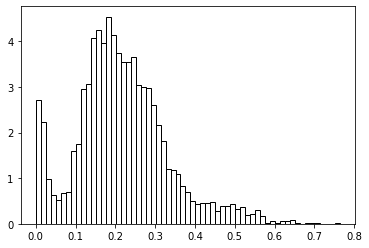

In [9]:
y,x,_=plt.hist(data,int(transit.nbbins),alpha=1,label='data',facecolor="none",edgecolor='black', density=True) 

In [10]:
x

array([0.        , 0.01253616, 0.02507232, 0.03760849, 0.05014465,
       0.06268081, 0.07521697, 0.08775313, 0.1002893 , 0.11282546,
       0.12536162, 0.13789778, 0.15043394, 0.16297011, 0.17550627,
       0.18804243, 0.20057859, 0.21311475, 0.22565092, 0.23818708,
       0.25072324, 0.2632594 , 0.27579556, 0.28833173, 0.30086789,
       0.31340405, 0.32594021, 0.33847637, 0.35101254, 0.3635487 ,
       0.37608486, 0.38862102, 0.40115718, 0.41369335, 0.42622951,
       0.43876567, 0.45130183, 0.46383799, 0.47637416, 0.48891032,
       0.50144648, 0.51398264, 0.5265188 , 0.53905497, 0.55159113,
       0.56412729, 0.57666345, 0.58919961, 0.60173578, 0.61427194,
       0.6268081 , 0.63934426, 0.65188042, 0.66441659, 0.67695275,
       0.68948891, 0.70202507, 0.71456123, 0.7270974 , 0.73963356,
       0.75216972, 0.76470588])

We are storing into x and y the density data : 
- x is the limits of bins
- y is the density value of each bins


### Fitting 2 distributions to the histogram

x including the limits of the bins, it contain 1 more element than y. 
To perform a regression, we need a y for each x, so we are transforming x into a list of median value of each bin : 

In [11]:
x=(x[1:]+x[:-1])/2 # lower limit + higher limit divided by 2

In [12]:
x

array([0.00626808, 0.01880424, 0.03134041, 0.04387657, 0.05641273,
       0.06894889, 0.08148505, 0.09402122, 0.10655738, 0.11909354,
       0.1316297 , 0.14416586, 0.15670203, 0.16923819, 0.18177435,
       0.19431051, 0.20684667, 0.21938284, 0.231919  , 0.24445516,
       0.25699132, 0.26952748, 0.28206365, 0.29459981, 0.30713597,
       0.31967213, 0.33220829, 0.34474446, 0.35728062, 0.36981678,
       0.38235294, 0.3948891 , 0.40742527, 0.41996143, 0.43249759,
       0.44503375, 0.45756991, 0.47010608, 0.48264224, 0.4951784 ,
       0.50771456, 0.52025072, 0.53278689, 0.54532305, 0.55785921,
       0.57039537, 0.58293153, 0.5954677 , 0.60800386, 0.62054002,
       0.63307618, 0.64561234, 0.65814851, 0.67068467, 0.68322083,
       0.69575699, 0.70829315, 0.72082932, 0.73336548, 0.74590164,
       0.7584378 ])

Now that we have the data of the saturation density, we will use it to identify the underlying distribution of essential and non-essential genes.
We can see from the histogram that the saturation index have a bimodal distribution. A regression will allow us to fit one distribution to each mode. With the parameters estimated by the regression, we can calculate the probability of each gene to belong to one or the other distribution.


I researched how to fit distributions to bimodal distributions, and found a couple of example of the curve_fit function from scipy. (https://www.geeksforgeeks.org/scipy-curve-fitting/, https://stackoverflow.com/questions/47110254/fitting-two-gaussians-on-less-expressed-bimodal-data/47133018, https://stackoverflow.com/questions/35990467/fit-two-gaussians-to-a-histogram-from-one-set-of-data-python)

We are using the probability density function of the model distribution, as we have used the probability density function for the saturation disatribution.

We start by defining the expected shape of the binomial distribution. A bimodal distribution pdf can be defined as the sum of two distribution pdf, such as the sum  of AUCs of the two pdfs equal 1 between 0 and 1.
Here, we define our saturation index distribution as the sum of an exponential and a gamma distributions, as identified in Goodall et al.

In [13]:
def bimodal2(x,loc_expon, scale_expon, a_gamma ,loc_gamma, scale_gamma): 
    return stats.expon.pdf(x, loc_expon, scale_expon)+stats.gamma.pdf(x,a_gamma ,loc_gamma, scale_gamma)

We also need to provide the expected parameters of the distribution. This allows the fitting method to anchor the research of true parameters. 

To determine these parameters, I researched the distributions and their parameters.

Lets start with the exponential distribution (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html)
The standard probability function for the exponential distribution is $f(x)=exp(-x)$. 

The $loc$ parameter shift the distribution, and the scale parameter scale it such as 

${\text{expon.pdf}(x,loc,scale)} =  { {{\text{expon.pdf}}({{x-loc}\over{scale}}) }  \over {scale} }$

The example in the manual page shows an exponential with the parameters $loc=0.5$ and $y=0.99$

Let's see what is the result in our interval $[0,1]$


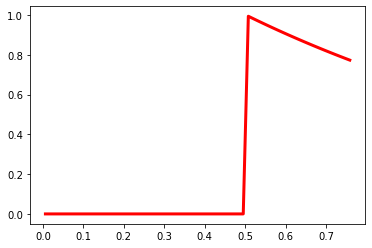

In [14]:
plt.plot(x,stats.expon.pdf(x, 0.5, 0.999),color='red',lw=3,label='Exponential distribution')

The highest point of this distribution is for x=0, let's see what happens if we chancge the loc parameter to 0

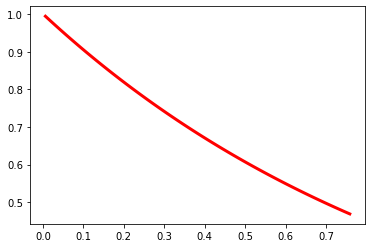

In [15]:
plt.plot(x,stats.expon.pdf(x, 0, 0.999),color='red',lw=3,label='Exponential distribution')

This is better, but the slope is too mild, and the values too low (1 on the y axis instead of 3). Since the probability is divided by the scale, then reducing the scale should increase the values. Since the AUC is constant, increasing the value should increase the slope.
Let's see 

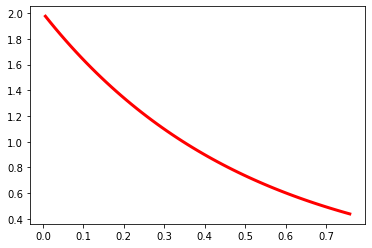

In [16]:
plt.plot(x,stats.expon.pdf(x, 0, 0.5),color='red',lw=3,label='Exponential distribution')

This is better, more in that direction :

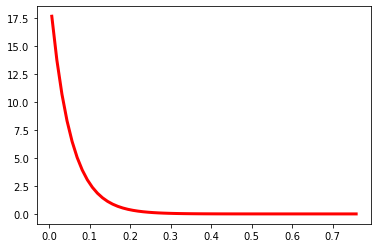

In [17]:
plt.plot(x,stats.expon.pdf(x, 0, 0.05),color='red',lw=3,label='Exponential distribution')

The slope angle looks good, but the y are too high, and the 0 point happens at a x too high. The highest point of the left mode of our distribution is between 2.5 and 3. This curve seem to reach this point at x=0.1 . Let's try to move the curve 0.1 to the left:

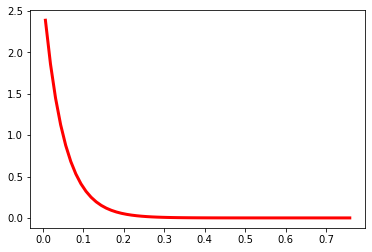

In [18]:
plt.plot(x,stats.expon.pdf(x, -0.1, 0.05),color='red',lw=3,label='Exponential distribution')

This looks good. Now we are doing the same thing with the gamma distribution : 

The pdf of gamma as a generalized form of : 

${{f}(x,a)} ={  {x^{a-1} \text{exp}(-x)}  \over  {\Gamma(a)}   }$  

where $\Gamma(a)$ is the gamma function and  $a$ a shape parameter

(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html)

like the exponential distribution, the gamma distribution can be shifted or scaled with 

${\text{gamma.pdf}(x,loc,scale)} =  { {{\text{gamma.pdf}}({{x-loc}\over{scale}},a) }  \over {scale} }$

The example in the manual of the function uses the parameters $a=1.99$, $loc=0.5$, and $scale=0.999$


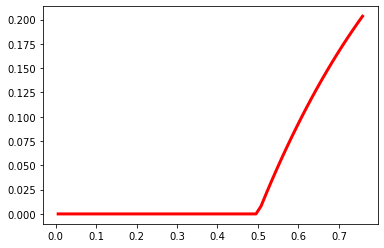

In [19]:
plt.plot(x,stats.gamma.pdf(x, 1.99,0.5, 0.999),color='red',lw=3,label='Gamma distribution')

The function is equal to 0 until x is the value of the loc parameter. In our distribution, it looks like the distribution start increaseing at 0.05. Let's try using  $loc=0.05$. It also seems like we have the increase part of the distribution, and the rest is out of our interval. Let's try reducing it as well.

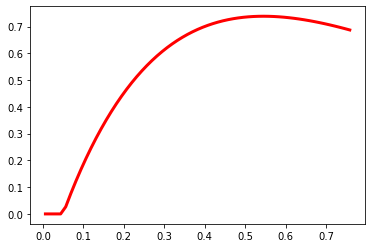

In [20]:
plt.plot(x,stats.gamma.pdf(x, 1.99,0.05, 0.5),color='red',lw=3,label='Gamma distribution')

We now have a curve which seem to be a little to large, and with y values too low.
To try and understand the the impact of the shape parameter $a$ on the curve, we can take a look at the wikipedia page for the gamma distribution (https://en.wikipedia.org/wiki/Gamma_distribution)

We notice that the function we are using seem to lack a parameter, as the formula reported in wikipedia has two parameters. However, the second parameter is a scale parameter which is the scale parameter already included in the stats.gamma function.

Indeed, if we compare the 2 formulas : 

Wikipedia : ${f(x,a,\Theta)}={ {\Theta^{a}x^{a-1}e^{-\Theta x} }  \over {\Gamma(a)} }$

stats.gamma : 

- ${{pdf}(x,a)} ={  {x^{a-1} \text{e}(-x)}  \over  {\Gamma(a)}   }$  
- ${\text{gamma.pdf}(x,loc,scale)} =  { {{\text{gamma.pdf}}(y,a) }  \over {scale} }$
- ${y}={{x-loc} \over {scale} } $


=>  ${{f}(x,a,loc,scale)} = {{  {y^{a-1} \text{exp}(-y)}  \over  {\Gamma(a)}   } \over {scale}}$  


=> $ {f(x, a,loc,scale) }={{  { { {{x - loc} \over { scale}}^{a-1} } {e^{{-(x-loc)} \over {scale}}  }} \over {\Gamma(a)} } \over {scale}} $


=>  $ {f(x, a,loc,scale) } ={  {{{ (x - loc)^{a - 1} } \over {scale^{a}}}  e^{{-(x - loc)}\over{scale}}} \over {\Gamma(a)}  }$




 
 So if $loc=0$

=>  $ {f(x, a,scale) } ={  {{{ x^{a - 1} } \over {scale^{a}}} e^{{-x}\over{scale}}} \over {\Gamma(a)}  }$


=>  $ {f(x, a,scale) } ={  {{{ x^{a - 1} } \over {scale^{a}}} } {{ e^{{-x}\over{scale}}} \over {\Gamma(a)}  }}$



 if $scale =  {1\over \Theta}$ 
 
=>  $ {f(x, a,\Theta) } ={  {{{{ x^{a - 1} } {\Theta^{a}}} }{ e^{{-x}{\Theta}}} \over {\Gamma(a)}  }}$

Which is the formula found on wikipedia.

We can then take a look at the gamma distribution shape, remembering that $k=a$ and $\Theta={1 \over scale}$






<img src="../Images/Gamma_distribution_shape.png" alt="Impact of parameters on the Gamma distribution shape" style="width: 600px;"/>

We can see that, at $\Theta$ egal, a higher $k$ ($a$)lead to a lower and wider 'bell' curve, and also seam to lead to less skew.A higher $\Theta$ (so a lower scale) , seem to lead to higher and narrower "bells".

The latest trial has a 'bell' curve too low and wide. Let's try then to reduce $a$ and $scale$. To simplify we will change on at a time. let's start with $a$ (we need to avoid a=1 and a integer, as they correspond to particular cases)

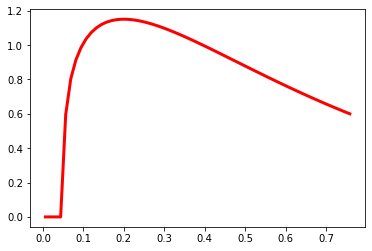

In [21]:
plt.plot(x,stats.gamma.pdf(x, 1.3,0.05, 0.5),color='red',lw=3,label='Gamma distribution')

In this case, the curve is very skewed on the left, lets try to only change the scale

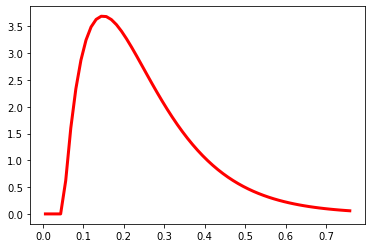

In [22]:
plt.plot(x,stats.gamma.pdf(x, 1.99,0.05, 0.1),color='red',lw=3,label='Gamma distribution')

The dimension of the curve seems better, we may need a bit higher and narrower still   

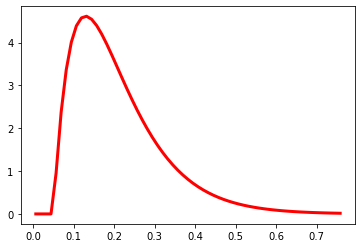

In [23]:
plt.plot(x,stats.gamma.pdf(x, 1.99,0.05, 0.08),color='red',lw=3,label='Gamma distribution')

Let's try the regression with these parameters as anchors for the bimodal distribution : 




In [24]:
expected=( -0.1, 0.05,1.99, 0.05, 0.08)


We now run the curve_fit function, with the expected shape, the data to fit, and the expected parameters. The function return 2 arrays: one with the parameters, one with the covariances

In [25]:
params,cov=curve_fit(bimodal2,x,y,expected) 


We use the covariances to calculate the standard deviations.

In [26]:
sigma=sqrt(diag(cov))

In [27]:
sigma

array([0.00837634, 0.00435514, 0.3950263 , 0.01013664, 0.00532531])

In [28]:
#Creation of the parameter dataframe
param_df=pd.DataFrame(data={'Parameters':params,'Sigma':sigma},index=bimodal2.__code__.co_varnames[1:])

We now store the parameters and sigma in a dataframe, for easier manipulation:

In [29]:
param_df

,Parameters,Sigma
loc_expon,-0.059444,0.008376
scale_expon,0.025213,0.004355
a_gamma,3.156730,0.395026
loc_gamma,0.052721,0.010137
scale_gamma,0.059513,0.005325


Let's take a look at how our estimated distribution fit with our data,

In [30]:
loc_expon=param_df.loc['loc_expon','Parameters'] 
scale_expon=param_df.loc['scale_expon','Parameters'] 
a_gamma=param_df.loc['a_gamma','Parameters'] 
loc_gamma=param_df.loc['loc_gamma','Parameters'] 
scale_gamma=param_df.loc['scale_gamma','Parameters']

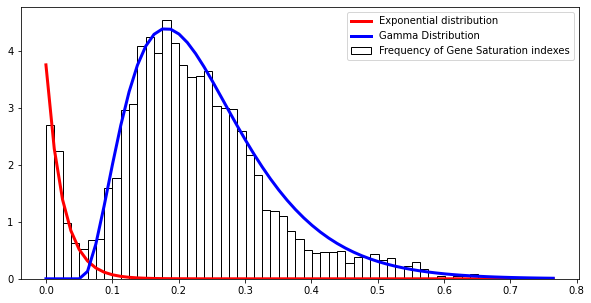

In [31]:
fig=plt.figure(figsize=(10,5))
y,x,_=plt.hist(data,int(transit.nbbins),alpha=1,label='Frequency of Gene Saturation indexes',facecolor="none",edgecolor='black', density=True)
plt.plot(x,stats.expon.pdf(x,loc_expon,scale_expon),color='red',lw=3,label='Exponential distribution')
plt.plot(x,stats.gamma.pdf(x, a_gamma, loc_gamma, scale_gamma),color='blue',lw=3,label='Gamma Distribution')
legend()
plt.savefig('results/fitting.png')

This look good. Now we will be using the estimated distribution to calculate the probability of each gene to belong to either distribution.


### Relation between the prior probability and the posterior probability

The Goodall and al. paper classifies a gene as non essential if $log_2({p(gamma|x)}\over {p(expon|x)}) > 12$ , and essential if $log_2({p(gamma|x)}\over {p(expon|x)}) < -12$

WThe only probability we have from the regression, are the cumulative density function (cdf) of our distributions.

$D.cdf(x)$ is the probability for an element of the distribution D to have a value equal of inferior to x.
It can also be seen as the prior probability of x knowing that distribution D is true:  $p(x|D)$

We are interested in the posterior probability of the distribution knowing x : $p(D|x)$

According to the Baye's theorem, the relation between the two probabilities is : ${p(D|x)}={{ {p(x|D)} \over {p(x)}} p{D}}$ 

with $p(x)$ the overall likelihood of the observation x. $p(x)$


https://www.britannica.com/topic/Bayess-theorem

---------------------------------------------------


### Bayes for continuous

To calculate the probability of genes to belong to each distribution, we use a bayes classifier (https://xavierbourretsicotte.github.io/Optimal_Bayes_Classifier.html), that calculates the score for each gene. The score is calculated using the pdf (probability density function), wich provide the relative likelihood of a value to belong to the population(or posterior probability https://en.wikipedia.org/wiki/Probability_density_function) :

In [32]:
def predict_Bayes_class(dataframe,loc_expon, scale_expon, a_gamma ,loc_gamma, scale_gamma): 
    #Returns the predicted class from an optimal bayes classifier - distributions must be known
    X=dataframe.insRate
    scoreES = scipy.stats.expon.pdf(X,loc_expon, scale_expon)
    dataframe['score_ES']=scoreES
    scoreNE = scipy.stats.gamma.pdf(X,a_gamma ,loc_gamma, scale_gamma)
    dataframe['score_NE']=scoreNE
    return dataframe

In [33]:
transit.full=predict_Bayes_class(transit.full,loc_expon, scale_expon, a_gamma ,loc_gamma, scale_gamma)

We caompute the ratio of probabilities, then the log_2 of the ration, and finally the classification using a threshold 12:

In [34]:
transit.full['bayes_ratio']=transit.full['score_ES']/transit.full['score_NE']

In [35]:
transit.full['bayes_log']='.'
for i,row in transit.full.iterrows():
    transit.full.loc[i,'bayes_log']=math.log(transit.full.loc[i,'bayes_ratio'],2)


In [36]:
transit.full['Bayes_class']='U'
for i,row in transit.full[transit.full.bayes_log>=12.0].iterrows():
    transit.full.loc[i,'Bayes_class']='ES'
for i,row in transit.full[transit.full.bayes_log<=-12.0].iterrows():
    transit.full.loc[i,'Bayes_class']='NE'

Predicted essential genes:

In [37]:
transit.get_ess('Bayes_class')

,ID,name,annot,nbIns,nbsites,r,ovr,span,pval,postprob,call,insRate,score_ES,score_NE,bayes_ratio,bayes_log,Bayes_class
20,BW25113_0023,rpsT,-,2,261,139,142,190,0.00000,0.00000,E,0.007663,2.769832,0.0,inf,inf,ES
22,BW25113_0025,ribF,-,14,939,284,284,284,0.00000,0.00000,E,0.014909,2.077920,0.0,inf,inf,ES
23,BW25113_0026,ileS,isoleucine tRNA synthetase,25,2814,450,450,450,0.00000,0.00000,E,0.008884,2.638858,0.0,inf,inf,ES
24,BW25113_0027,lspA,prolipoprotein signal peptidase (SPase II),8,492,148,148,148,0.00000,0.00000,E,0.016260,1.969532,0.0,inf,inf,ES
26,BW25113_0029,ispH,-,12,948,290,290,290,0.00000,0.00000,E,0.012658,2.271993,0.0,inf,inf,ES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258,BW25113_4621,yjbS,-,5,201,104,104,104,0.00001,0.00017,E,0.024876,1.399459,0.0,inf,inf,ES
4274,BW25113_4672,ymiB,-,3,102,40,40,40,1.00000,1.00000,NE,0.029412,1.169027,0.0,inf,inf,ES
4275,BW25113_4674,ynbG,-,0,63,63,66,212,0.00000,0.00000,E,0.000000,3.753592,0.0,inf,inf,ES
4278,BW25113_4677,yobI,-,2,63,39,39,68,0.07793,0.58730,NE,0.031746,1.065654,0.0,inf,inf,ES


### Comparison with the paper results

We import the paper results in the dataframe

In [38]:
paper=pd.read_csv(DATA_DIR+'Goodall_results.csv', sep=",", header=1, comment='#').fillna(value = '.')

transit.full['paper']='NA'
for i,row in transit.full.iterrows():
    name=str(row['name'])
    essentiality = paper[paper["Gene"]==name].Essential
    unclear = paper[paper["Gene"]==name].Unclear
    if len(essentiality)==1:
        if unclear.values[0]==True:
            transit.full.loc[i,'paper']="U"
        elif essentiality.values[0]==True:
            transit.full.loc[i,'paper']="ES"
        else:
            transit.full.loc[i,'paper']="NE"
    elif len(essentiality)>1 :
        if [x for x in unclear][0]==True:
            transit.full.loc[i,'paper']="U"
        elif [x for x in essentiality][0]==True:
            transit.full.loc[i,'paper']="ES"
        else:
            transit.full.loc[i,'paper']="NE"
    else :
        transit.full.loc[i,'paper']="."



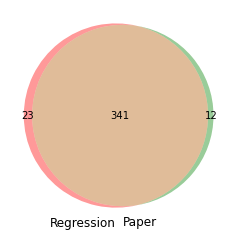

In [39]:
venn2( [set(transit.get_ess('Bayes_class').name),set(transit.get_ess('paper').name)],set_labels = ('Regression','Paper'))
plt.savefig('results/venn_temp.png')

### Add KEio predicion of essentiality <a id='add_keio'></a>

In [40]:
keio=pd.read_csv(DATA_DIR+'Keio_essential.csv', sep=",", header=1, comment='#').fillna(value = '.')



In [41]:
for i in [str(x) for x in keio.columns]:
    nam=re.sub(r"[0-9]\..", "", i)
    keio.rename(columns={i:nam},inplace=True)


In [42]:
keio_ess=pysqldf("SELECT * FROM keio where gene!='.' AND gene!='none'")

In [43]:
keio_ess_list=[str(x) for x in keio_ess.gene]

In [44]:
transit_wk=transit

In [45]:
transit_wk.full['keio']='NA'
for i,row in transit_wk.full.iterrows():
    name=str(row['name'])
    if name in keio_ess_list :
        transit_wk.full.loc[i,'keio']="ES"
    else:
        transit_wk.full.loc[i,'keio']="NE"



### Add PEC prediction of essentiality <a id='add_pec'></a>

In [46]:
pec=pd.read_csv(DATA_DIR+'PECData.dat', sep="\t", header=0, comment='#').fillna(value = '.')


In [47]:
for i in [str(x) for x in pec.columns]:
    nam=re.sub(r"\(.+\)", "", i)
    pec.rename(columns={i:nam},inplace=True)


In [48]:
transit_all=transit_wk

In [49]:
transit_all.full['pec']='NA'
for i,row in transit_all.full.iterrows():
    name=str(row['name'])
    essentiality = pec[pec["Orf"]==name].Class
    if len(essentiality)==1:
        pred=essentiality.values[0]
        if pred==1:
            transit_all.full.loc[i,'pec']="ES"
        elif pred==2:
            transit_all.full.loc[i,'pec']="NE"
        elif pred==3:
            transit_all.full.loc[i,'pec']="U"
    elif len(essentiality)>1:
        pred=[x for x in essentiality][0]
        if pred==1:
            transit_all.full.loc[i,'pec']="ES"
        elif pred==2:
            transit_all.full.loc[i,'pec']="NE"
        elif pred==3:
            transit_all.full.loc[i,'pec']="U"
    else :
        transit_all.full.loc[i,'pec']="."


### Add Bio-Tradis prediction of essentiality <a id='add_pec'></a>

In [50]:
biotrad_ess=pd.read_csv(DATA_DIR+'Biotradis.essen.csv', usecols=range(11), sep=",", header=0, comment='#').fillna(value = '.')
biotrad_ambig=pd.read_csv(DATA_DIR+'Biotradis.ambig.csv', usecols=range(11), sep=",", header=0, comment='#').fillna(value = '.')
biotrad_all=pd.read_csv(DATA_DIR+'Biotradis.all.csv', usecols=range(11), sep=",", header=0, comment='#').fillna(value = '.')

In [51]:
transit_all.full['biotradis']='NA'
for i,row in transit_all.full.iterrows():
    if row.ID in biotrad_ess.locus_tag.values:
        transit_all.full.loc[i,'biotradis']='ES'
    elif row.ID in biotrad_ambig.locus_tag.values:
        transit_all.full.loc[i,'biotradis']='U'
    elif row.ID in biotrad_all.locus_tag.values:
        transit_all.full.loc[i,'biotradis']='NE'

### Calssification with Threshold =4

In [52]:
transit.full['Bayes_class_4']='U'
for i,row in transit.full[transit.full.bayes_log>=4.0].iterrows():
    transit.full.loc[i,'Bayes_class_4']='ES'
for i,row in transit.full[transit.full.bayes_log<=-4.0].iterrows():
    transit.full.loc[i,'Bayes_class_4']='NE'

Saving the resulting dataframe

In [53]:
transit.full.to_csv("results/tradis_results_all_studies.tab", sep="\t")

## Upset Plots

Get sets of essential genes for each method

In [54]:
set_paper=set(transit_all.get_ess('paper').name)
set_transit=set(transit_all.get_ess('call').name)
set_bayes_12=set(transit_all.get_ess('Bayes_class').name)
set_bayes_4=set(transit_all.get_ess('Bayes_class_4').name)
set_pec=set(transit_all.get_ess('pec').name)
set_keio=set(transit_all.get_ess('keio').name)
set_biotradis=set(transit_all.get_ess('biotradis').name)


Data to use :
- list of genes belonging to a set 
- name of a set ('Regression Threshold=12', 'Transit'...)
- name of a combination (A, AB, AC, BC, ABC..)
- size of set intersections

Setting dictionnaries to organize the intersection data : 
- dic_set : Atttach the name to the list of gene for all set combinations
- dic_com : Attach the labels to the names of all combinations
- dic_name : Attach the name to the Label of single sets
- dic tot : Contain the size of sets for all combinations



In [55]:
dic_sets={}
dic_comb={}
dic_name={}
dic_tot={}
dic_name['A']='Paper'
dic_name['B']='Transit'
dic_name['C']='Reg X=12'
dic_name['D']='Reg X=4'
dic_name['E']='PEC'
dic_name['F']='Keio'
dic_name['G']='Bio-Tradis'
dic_sets['Paper']=set(set_paper)
dic_sets['Transit']=set(set_transit)
dic_sets['Reg X=12']=set(set_bayes_12)
dic_sets['Reg X=4']=set(set_bayes_4)
dic_sets['PEC']=set(set_pec)
dic_sets['Keio']=set(set_keio)
dic_sets['Bio-Tradis']=set(set_biotradis)

Creation of a dictionnary containing all possible combination between the members of a list. Key is a combination name, values is the list of labels contained in the combination

In [56]:
stuff=['A','C','E','F']
for i in stuff:
    dic_comb[i]=dic_name[i]
for i in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, i):
        if len(subset)>1:
            dic_comb["".join(subset)]=[dic_name[i] for i in subset]
        elif len(subset)==1:
            dic_comb["".join(subset)]=[dic_name[subset[0]]]
        else:
            dic_comb["".join(subset)]=[]

Calculation of intersection sets, and theiir sizes. A combination ABC in a space containing A,B,C, and D is the intersection of A, B, and C ensembles, excluding the genes belonging to D.

In [57]:
for i in dic_comb.keys():
    if len(dic_comb[i])>1:
        intset=dic_sets[dic_comb[i][0]]
        for j in dic_comb[i][1:]:
            intset=intset.intersection(dic_sets[j])
        compl=[x for x in np.setdiff1d(dic_comb['ACEF'],dic_comb[i])]
        for k in compl:
            intset=intset.difference(dic_sets[k])
    elif len(dic_comb[i])==1:
        intset=dic_sets[dic_comb[i][0]]
        compl=[i for i in np.setdiff1d(dic_comb['ACEF'],dic_comb[i])]
        for k in compl:
            intset=intset.difference(dic_sets[k])
    else:
        intset=[]
    dic_tot[i]=len(intset)

Creation of a lists containing :
- The list of combination labels list
- The list of combination set size

These list are input to the 'from_memberships' function that create the matrix to input to the upset plot.

In [58]:
values=[i[1] for i in sorted(dic_tot.items(),key =  lambda kv:(kv[1])  , reverse=True  )]
combin=[dic_comb[i[0]] for i in sorted(dic_tot.items(),key =  lambda kv:(kv[1])  , reverse=True  )]
transit_upset = from_memberships(combin,data=values)

In [59]:
transit_upset

Keio   PEC    Paper  Reg X=12
True   True   True   True        230
False  False  True   True         66
       True   True   True         35
True   False  False  False        15
       True   False  False        14
False  True   False  True         13
       False  True   False        10
              False  True         10
True   False  True   True         10
False  True   False  False         8
True   True   True   False         2
False  False  False  False         0
       True   True   False         0
True   False  True   False         0
              False  True          0
       True   False  True          0
dtype: int64

#### Plot of the upSet plot. 

The plots can be organised by combination degrees with the option " sort_by='degree' ". It means that the first collumns correspond to genes contained in only one set, then in two sets, etc...

It can be organised by size of intersections with the option " sort_by='cardinality' ".

##### Essential genes

<Figure size 2160x1080 with 0 Axes>

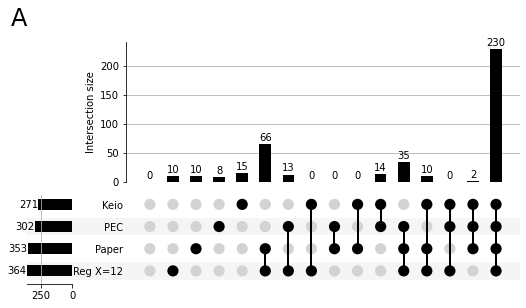

In [60]:
fig=plt.figure(figsize=(30,15))

upplot(transit_upset, sort_by='degree',orientation='horizontal', show_counts='%d')
plt.suptitle('A',x=0.1, y=0.99 , fontsize=24 ,verticalalignment='top',horizontalalignment='left')
plt.savefig('results/upset_ess_reg12.png')
plt.show()

Comparison of thresholds for gene essentiality prediction (Figure 3A)

<Figure size 2160x1080 with 0 Axes>

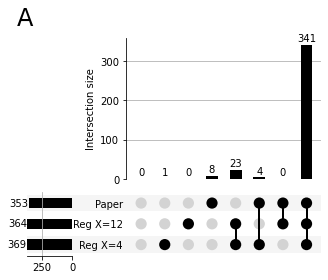

In [61]:
dic_sets={}
dic_comb={}
dic_name={}
dic_tot={}
dic_name['A']='Paper'
dic_name['B']='Reg X=4'
dic_name['C']='Reg X=12'
dic_sets['Paper']=set(set_paper)
dic_sets['Reg X=12']=set(set_bayes_12)
dic_sets['Reg X=4']=set(set_bayes_4)


stuff=['A','B','C']
for i in stuff:
    dic_comb[i]=dic_name[i]
for i in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, i):
        if len(subset)>1:
            dic_comb["".join(subset)]=[dic_name[i] for i in subset]
        elif len(subset)==1:
            dic_comb["".join(subset)]=[dic_name[subset[0]]]
        else:
            dic_comb["".join(subset)]=[]

for i in dic_comb.keys():
    if len(dic_comb[i])>1:
        intset=dic_sets[dic_comb[i][0]]
        for j in dic_comb[i][1:]:
            intset=intset.intersection(dic_sets[j])
        compl=[x for x in np.setdiff1d(dic_comb['ABC'],dic_comb[i])]
        for k in compl:
            intset=intset.difference(dic_sets[k])
    elif len(dic_comb[i])==1:
        intset=dic_sets[dic_comb[i][0]]
        compl=[i for i in np.setdiff1d(dic_comb['ABC'],dic_comb[i])]
        for k in compl:
            intset=intset.difference(dic_sets[k])
    else:
        intset=[]
    dic_tot[i]=len(intset)

values=[i[1] for i in sorted(dic_tot.items(),key =  lambda kv:(kv[1])  , reverse=True  )]
combin=[dic_comb[i[0]] for i in sorted(dic_tot.items(),key =  lambda kv:(kv[1])  , reverse=True  )]
transit_upset = from_memberships(combin,data=values)

fig=plt.figure(figsize=(30,15))

upplot(transit_upset, sort_by='degree',orientation='horizontal', show_counts='%d')
plt.suptitle('A',x=0.1, y=0.99 , fontsize=24 ,verticalalignment='top',horizontalalignment='left')
plt.savefig('results/upset_ess_reg_comp.png')
plt.show()

Comparison with Biotradis for gene essentiality prediction (Figure 3C)

<Figure size 2160x1080 with 0 Axes>

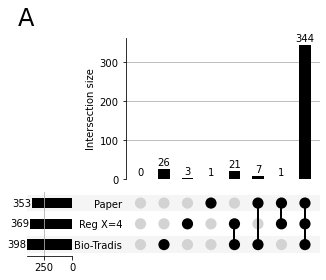

In [62]:
dic_sets={}
dic_comb={}
dic_name={}
dic_tot={}
dic_name['A']='Paper'
dic_name['B']='Reg X=4'
dic_name['C']='Bio-Tradis'
dic_sets['Paper']=set(set_paper)
dic_sets['Reg X=4']=set(set_bayes_4)
dic_sets['Bio-Tradis']=set(set_biotradis)


stuff=['A','B','C']
for i in stuff:
    dic_comb[i]=dic_name[i]
for i in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, i):
        if len(subset)>1:
            dic_comb["".join(subset)]=[dic_name[i] for i in subset]
        elif len(subset)==1:
            dic_comb["".join(subset)]=[dic_name[subset[0]]]
        else:
            dic_comb["".join(subset)]=[]

for i in dic_comb.keys():
    if len(dic_comb[i])>1:
        intset=dic_sets[dic_comb[i][0]]
        for j in dic_comb[i][1:]:
            intset=intset.intersection(dic_sets[j])
        compl=[x for x in np.setdiff1d(dic_comb['ABC'],dic_comb[i])]
        for k in compl:
            intset=intset.difference(dic_sets[k])
    elif len(dic_comb[i])==1:
        intset=dic_sets[dic_comb[i][0]]
        compl=[i for i in np.setdiff1d(dic_comb['ABC'],dic_comb[i])]
        for k in compl:
            intset=intset.difference(dic_sets[k])
    else:
        intset=[]
    dic_tot[i]=len(intset)

values=[i[1] for i in sorted(dic_tot.items(),key =  lambda kv:(kv[1])  , reverse=True  )]
combin=[dic_comb[i[0]] for i in sorted(dic_tot.items(),key =  lambda kv:(kv[1])  , reverse=True  )]
transit_upset = from_memberships(combin,data=values)

fig=plt.figure(figsize=(30,15))

upplot(transit_upset, sort_by='degree',orientation='horizontal', show_counts='%d')
plt.suptitle('A',x=0.1, y=0.99 , fontsize=24 ,verticalalignment='top',horizontalalignment='left')
plt.savefig('results/biotard_init.png')
plt.show()

Comparison with other Studies (Figure 5A)

<Figure size 2160x1080 with 0 Axes>

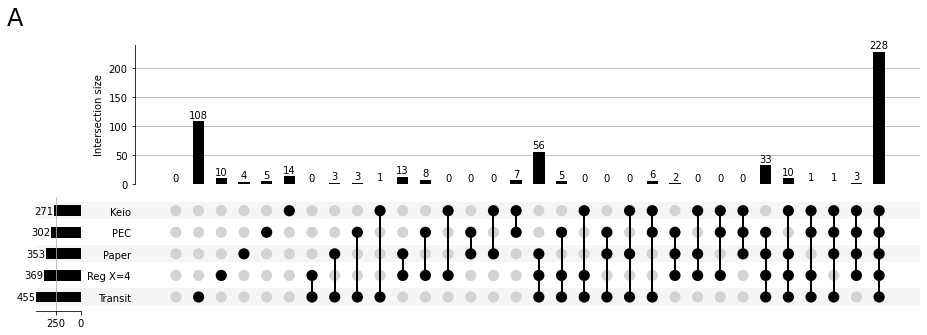

In [63]:
dic_sets={}
dic_comb={}
dic_name={}
dic_tot={}
dic_name['A']='Paper'
dic_name['B']='Transit'
dic_name['C']='Reg X=4'
dic_name['D']='PEC'
dic_name['E']='Keio'
dic_sets['Paper']=set(set_paper)
dic_sets['Transit']=set(set_transit)
dic_sets['Reg X=4']=set(set_bayes_4)
dic_sets['PEC']=set(set_pec)
dic_sets['Keio']=set(set_keio)

stuff=['A','B','C','D','E']
for i in stuff:
    dic_comb[i]=dic_name[i]
for i in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, i):
        if len(subset)>1:
            dic_comb["".join(subset)]=[dic_name[i] for i in subset]
        elif len(subset)==1:
            dic_comb["".join(subset)]=[dic_name[subset[0]]]
        else:
            dic_comb["".join(subset)]=[]

for i in dic_comb.keys():
    if len(dic_comb[i])>1:
        intset=dic_sets[dic_comb[i][0]]
        for j in dic_comb[i][1:]:
            intset=intset.intersection(dic_sets[j])
        compl=[x for x in np.setdiff1d(dic_comb['ABCDE'],dic_comb[i])]
        for k in compl:
            intset=intset.difference(dic_sets[k])
    elif len(dic_comb[i])==1:
        intset=dic_sets[dic_comb[i][0]]
        compl=[i for i in np.setdiff1d(dic_comb['ABCDE'],dic_comb[i])]
        for k in compl:
            intset=intset.difference(dic_sets[k])
    else:
        intset=[]
    dic_tot[i]=len(intset)

values=[i[1] for i in sorted(dic_tot.items(),key =  lambda kv:(kv[1])  , reverse=True  )]
combin=[dic_comb[i[0]] for i in sorted(dic_tot.items(),key =  lambda kv:(kv[1])  , reverse=True  )]
transit_upset = from_memberships(combin,data=values)

fig=plt.figure(figsize=(30,15))

upplot(transit_upset, sort_by='degree',orientation='horizontal', show_counts='%d')
plt.suptitle('A',x=0.1, y=0.99 , fontsize=24 ,verticalalignment='top',horizontalalignment='left')
plt.savefig('results/upset_ess_all.png')
plt.show()

### List of non-essential genes <a id='list_ne'></a>

In [64]:
set_paper_ne=set(transit_all.get_ne('paper').ID)
set_transit_ne=set(transit_all.get_ne('call').ID)
set_bayes_12_ne=set(transit_all.get_ne('Bayes_class').ID)
set_bayes_4_ne=set(transit_all.get_ne('Bayes_class_4').ID)
set_pec_ne=set(transit_all.get_ne('pec').ID)
set_keio_ne=set(transit_all.get_ne('keio').ID)
set_biotradis_ne=set(transit_all.get_ne('biotradis').ID)

In [65]:
dic_sets={}
dic_comb={}
dic_name={}
dic_tot={}
dic_name['A']='Paper'
dic_name['B']='Transit'
dic_name['C']='Reg X=12'
dic_name['D']='Reg X=4'
dic_name['E']='PEC'
dic_name['F']='Keio'
dic_name['G']='Bio-Tradis'
dic_sets['Paper']=set(set_paper_ne)
dic_sets['Transit']=set(set_transit_ne)
dic_sets['Reg X=12']=set(set_bayes_12_ne)
dic_sets['Reg X=4']=set(set_bayes_4_ne)
dic_sets['PEC']=set(set_pec_ne)
dic_sets['Keio']=set(set_keio_ne)
dic_sets['Bio-Tradis']=set(set_biotradis_ne)

In [66]:
stuff=['A','C','D']
for i in stuff:
    dic_comb[i]=dic_name[i]
for i in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, i):
        if len(subset)>1:
            dic_comb["".join(subset)]=[dic_name[i] for i in subset]
        elif len(subset)==1:
            dic_comb["".join(subset)]=[dic_name[subset[0]]]
        else:
            dic_comb["".join(subset)]=[]

Calculation of intersection sets, and theiir sizes. A combination ABC in a space containing A,B,C, and D is the intersection of A, B, and C ensembles, excluding the genes belonging to D.

In [67]:
for i in dic_comb.keys():
    if len(dic_comb[i])>1:
        intset=dic_sets[dic_comb[i][0]]
        for j in dic_comb[i][1:]:
            intset=intset.intersection(dic_sets[j])
        compl=[x for x in np.setdiff1d(dic_comb['ACD'],dic_comb[i])]
        for k in compl:
            intset=intset.difference(dic_sets[k])
    elif len(dic_comb[i])==1:
        intset=dic_sets[dic_comb[i][0]]
        compl=[i for i in np.setdiff1d(dic_comb['ACD'],dic_comb[i])]
        for k in compl:
            intset=intset.difference(dic_sets[k])
    else:
        intset=[]
    dic_tot[i]=len(intset)

Creation of a lists containing :
- The list of combination labels list
- The list of combination set size

These list are input to the 'from_memberships' function that create the matrix to input to the upset plot.

In [68]:
values=[i[1] for i in sorted(dic_tot.items(),key =  lambda kv:(kv[1])  , reverse=True  )]
combin=[dic_comb[i[0]] for i in sorted(dic_tot.items(),key =  lambda kv:(kv[1])  , reverse=True  )]
transit_upset = from_memberships(combin,data=values)

<Figure size 2160x1080 with 0 Axes>

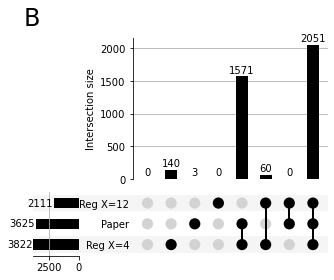

In [69]:
fig=plt.figure(figsize=(30,15))

upplot(transit_upset, sort_by='degree',orientation='horizontal', show_counts='%d')
plt.suptitle('B',x=0.1, y=0.99 , fontsize=24 ,verticalalignment='top',horizontalalignment='left')
plt.savefig('results/upset_ne_reg_comp.png')
plt.show()

Comparison with other Studies (Figure 5B)

<Figure size 2160x1080 with 0 Axes>

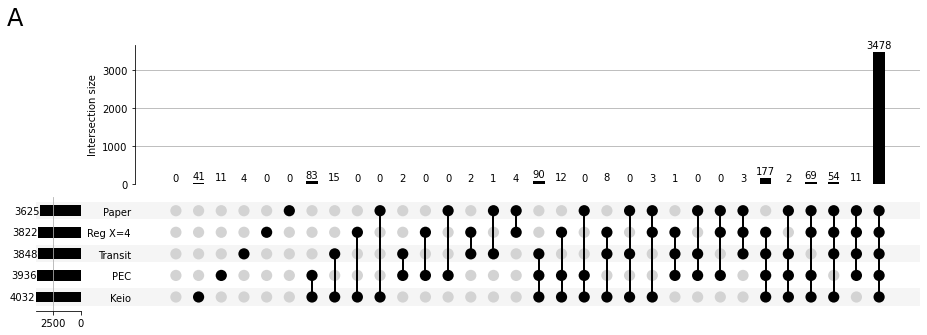

In [70]:
dic_sets={}
dic_comb={}
dic_name={}
dic_tot={}
dic_name['A']='Paper'
dic_name['B']='Transit'
dic_name['C']='Reg X=4'
dic_name['D']='PEC'
dic_name['E']='Keio'
dic_sets['Paper']=set(set_paper_ne)
dic_sets['Transit']=set(set_transit_ne)
dic_sets['Reg X=4']=set(set_bayes_4_ne)
dic_sets['PEC']=set(set_pec_ne)
dic_sets['Keio']=set(set_keio_ne)


stuff=['A','B','C','D','E']
for i in stuff:
    dic_comb[i]=dic_name[i]
for i in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, i):
        if len(subset)>1:
            dic_comb["".join(subset)]=[dic_name[i] for i in subset]
        elif len(subset)==1:
            dic_comb["".join(subset)]=[dic_name[subset[0]]]
        else:
            dic_comb["".join(subset)]=[]

for i in dic_comb.keys():
    if len(dic_comb[i])>1:
        intset=dic_sets[dic_comb[i][0]]
        for j in dic_comb[i][1:]:
            intset=intset.intersection(dic_sets[j])
        compl=[x for x in np.setdiff1d(dic_comb['ABCDE'],dic_comb[i])]
        for k in compl:
            intset=intset.difference(dic_sets[k])
    elif len(dic_comb[i])==1:
        intset=dic_sets[dic_comb[i][0]]
        compl=[i for i in np.setdiff1d(dic_comb['ABCDE'],dic_comb[i])]
        for k in compl:
            intset=intset.difference(dic_sets[k])
    else:
        intset=[]
    dic_tot[i]=len(intset)

values=[i[1] for i in sorted(dic_tot.items(),key =  lambda kv:(kv[1])  , reverse=True  )]
combin=[dic_comb[i[0]] for i in sorted(dic_tot.items(),key =  lambda kv:(kv[1])  , reverse=True  )]
transit_upset = from_memberships(combin,data=values)

fig=plt.figure(figsize=(30,15))

upplot(transit_upset, sort_by='degree',orientation='horizontal', show_counts='%d')
plt.suptitle('A',x=0.1, y=0.99 , fontsize=24 ,verticalalignment='top',horizontalalignment='left')
plt.savefig('results/upset_ne_all.png')
plt.show()

### Generation of venn diagram for essential genes comparison with Transit (Figure 4) <a id='venn_ess'></a>

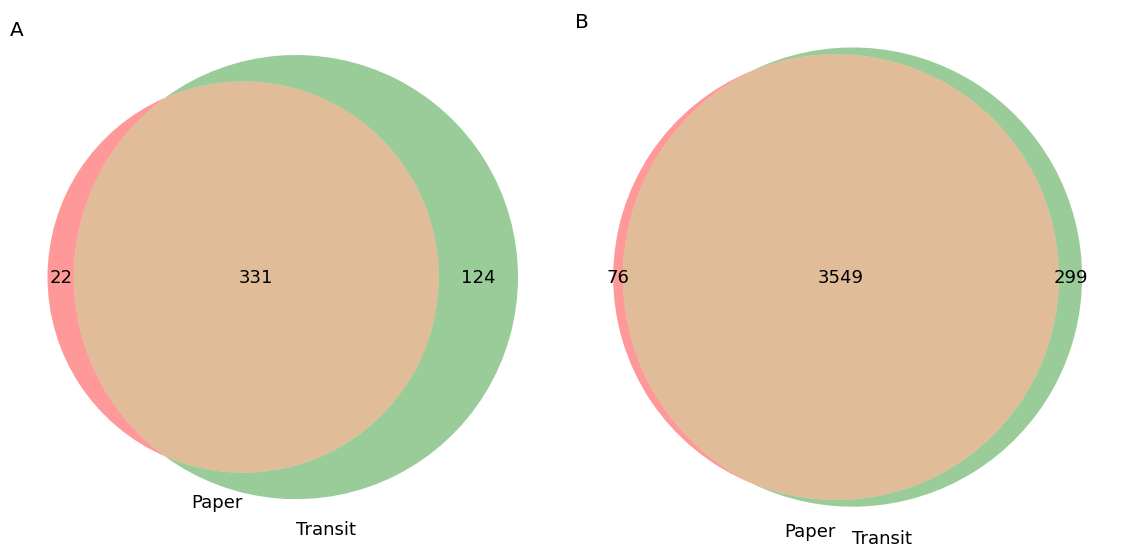

In [71]:

fig, ax = plt.subplots(figsize=(20,20))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.025, hspace=0.05)

plt.axis('on')

pltA=plt.subplot(gs1[0]).set_title('A', fontsize=20, loc='left',y=0.95,x=0.005)
Avenn=venn2([set_paper,set_transit],set_labels = ( 'Paper','Transit'))
0
pltB=plt.subplot(gs1[1]).set_title('B', fontsize=20, loc='left',y=0.95,x=0.005)
Bvenn=venn2( [set_paper_ne,set_transit_ne],set_labels = ('Paper','Transit'))


ax.set_aspect('equal')


for text in Avenn.set_labels:
    text.set_fontsize(18)
for text in Avenn.subset_labels:
    text.set_fontsize(18)
for text in Bvenn.set_labels:
    text.set_fontsize(18)
for text in Bvenn.subset_labels:
    text.set_fontsize(18)

plt.savefig('results/transit_paper.png')